In [245]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [246]:
aligned = cv2.imread('edge.jpeg')
misaligned = cv2.imread('non-edge.jpeg')

def imshow(img):
    import cv2
    import IPython
    _,ret = cv2.imencode('.jpg', img) 
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)

aligned_gray = cv2.cvtColor(aligned, cv2.COLOR_RGB2GRAY)
misaligned_gray = cv2.cvtColor(misaligned, cv2.COLOR_RGB2GRAY)

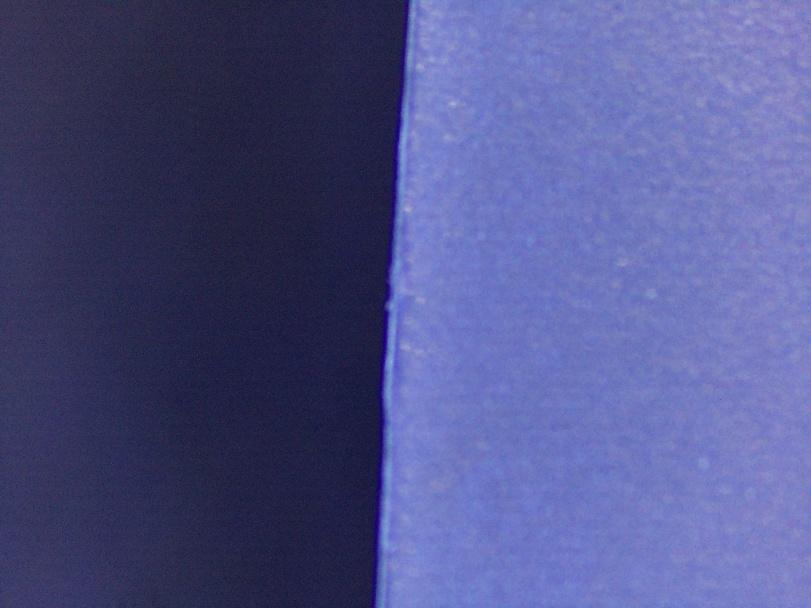

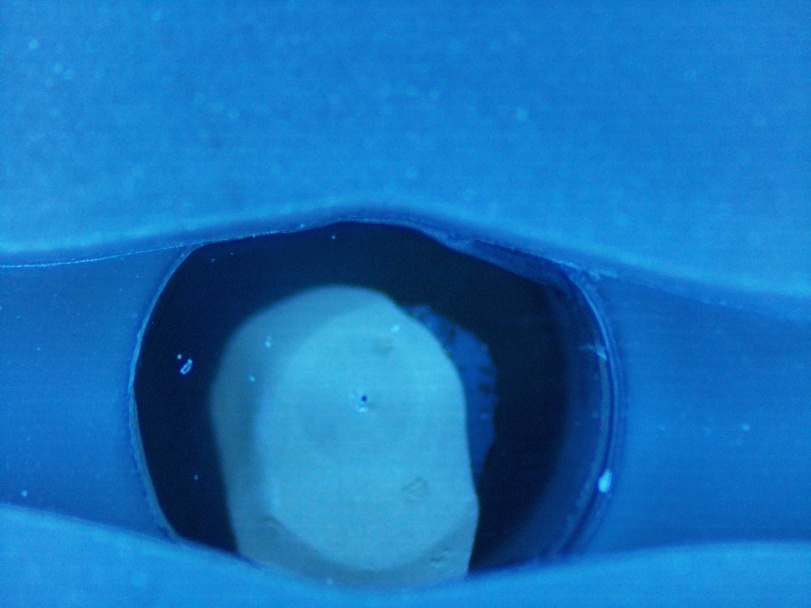

In [247]:
imshow(aligned)
imshow(misaligned)

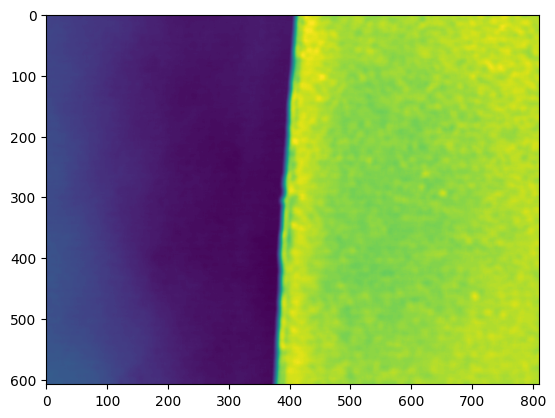

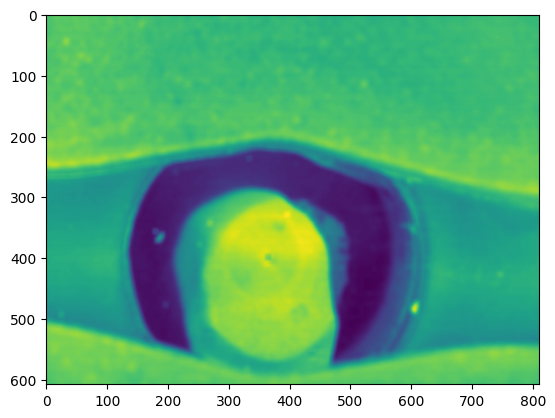

In [248]:
aligned_g = cv2.blur(aligned_gray, (10, 10))
misaligned_g = cv2.blur(misaligned_gray, (10, 10))
plt.figure(1)
plt.imshow(aligned_g)
plt.figure(2)
plt.imshow(misaligned_g)

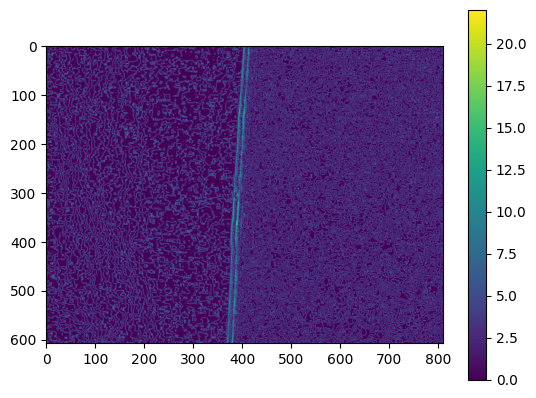

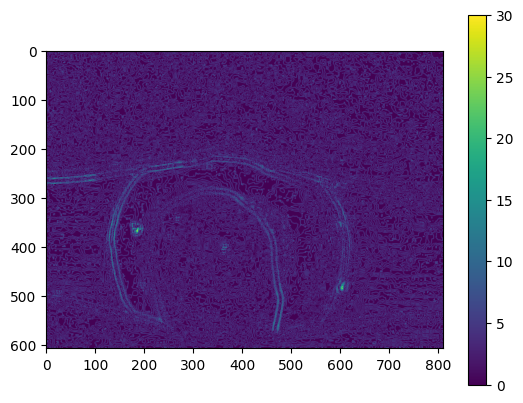

In [249]:
aligned_l_s = cv2.Laplacian(aligned_g, cv2.CV_16S, ksize=3)
misaligned_l_s = cv2.Laplacian(misaligned_g, cv2.CV_16S, ksize=3)

aligned_l = cv2.convertScaleAbs(aligned_l_s)
misaligned_l = cv2.convertScaleAbs(misaligned_l_s)

plt.figure(1)
plt.imshow(aligned_l)
plt.colorbar()
plt.figure(2)
plt.imshow(misaligned_l)
plt.colorbar()

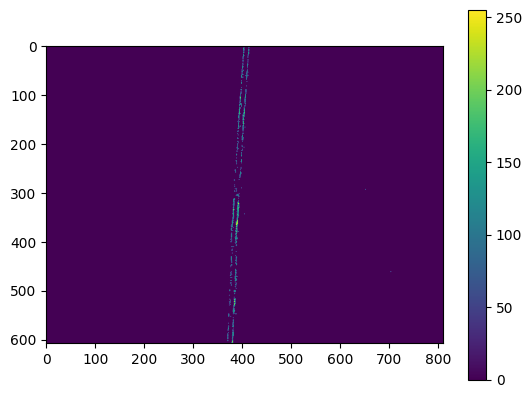

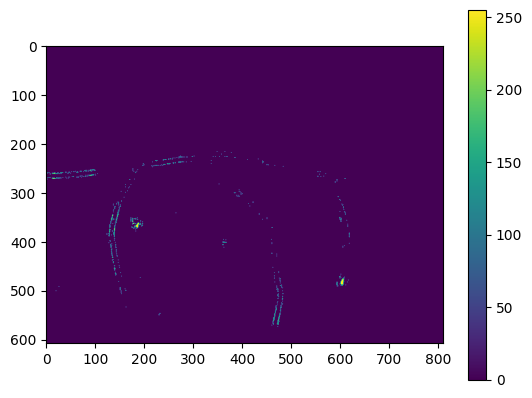

In [250]:
ret, aligned_t = cv2.threshold(aligned_l, 10, 255, cv2.THRESH_BINARY)
ret, misaligned_t = cv2.threshold(misaligned_l, 10, 255, cv2.THRESH_BINARY)

plt.figure(1)
plt.imshow(aligned_t)
plt.colorbar()
plt.figure(2)
plt.imshow(misaligned_t)
plt.colorbar()

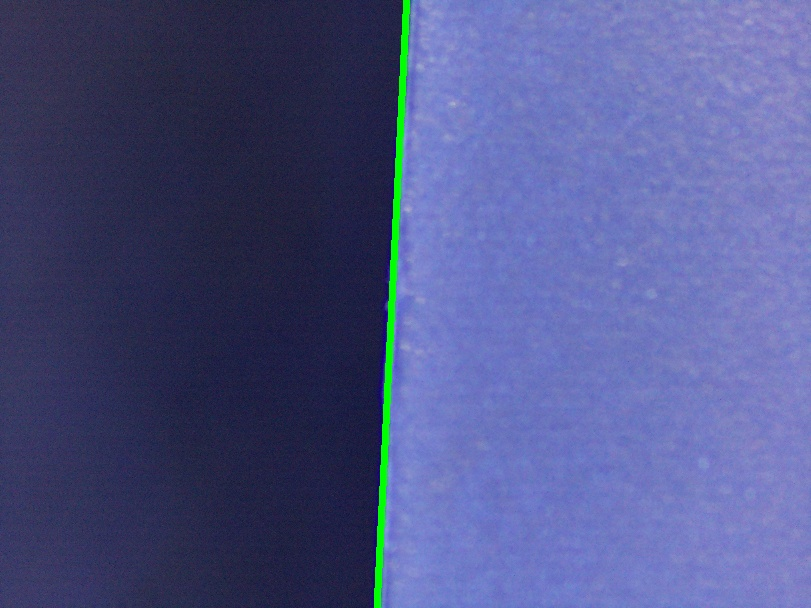

In [251]:
aligned_points = cv2.findNonZero(aligned_t)
a_vx, a_vy, a_cx, a_cy = cv2.fitLine(aligned_points, cv2.DIST_L2, 0, 0.01, 0.01)

h, w, _ = aligned.shape

aligned_line = aligned.copy()
cv2.line(aligned_line, (int(a_cx-a_vx*w), int(a_cy-a_vy*w)), (int(a_cx+a_vx*w), int(a_cy+a_vy*w)), (0, 255, 0), 5)

imshow(aligned_line)

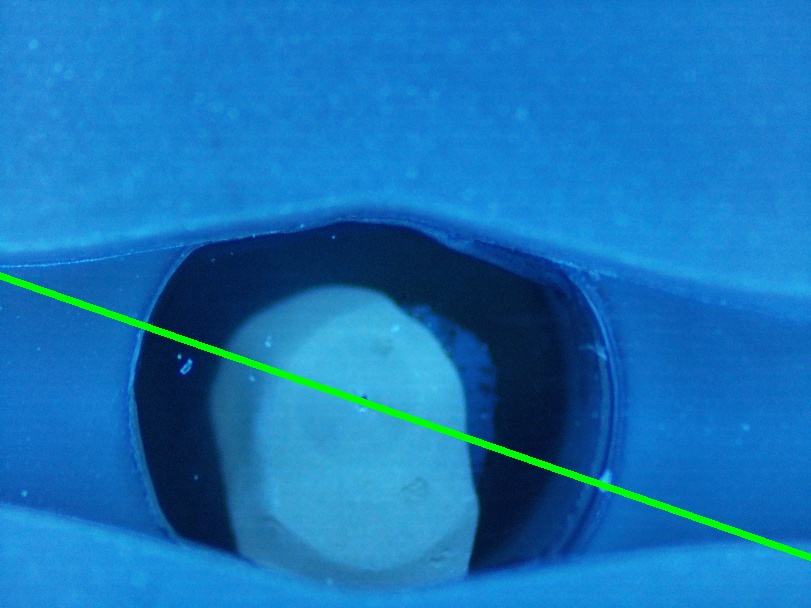

In [252]:
misaligned_points = cv2.findNonZero(misaligned_t)
m_vx, m_vy, m_cx, m_cy = cv2.fitLine(np.float32(misaligned_points), cv2.DIST_L2, 0, 0.001, 0.001)

h, w, _ = misaligned.shape

misaligned_line = misaligned.copy()
cv2.line(misaligned_line, (int(m_cx-m_vx*w), int(m_cy-m_vy*w)), (int(m_cx+m_vx*w), int(m_cy+m_vy*w)), (0, 255, 0), 5)

imshow(misaligned_line)

In [253]:
def build_r(theta):
    return np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])

def compute_error(points, vx, vy, cx, cy):
    points = np.squeeze(points, 1)
    v = np.array([vx[0], vy[0]])
    p = np.array([cx[0], cy[0]])

    # rotate fit to y axis
    theta = np.arccos(np.dot(v, [0, 1]) / np.linalg.norm(v))
    R = build_r(theta)

    rot_points = np.dot(R, (points-p).T)
    err = rot_points[0]**2
    return np.sqrt(np.einsum('i,i->',err,err) / len(points)), theta

err_g, theta_g = compute_error(aligned_points, a_vx, a_vy, a_cx, a_cy)
err_b, theta_b = compute_error(misaligned_points, m_vx, m_vy, m_cx, m_cy)
print("good", err_g, theta_g)
print("bad", err_b, theta_b)

good 3927.1475606573513 3.0924735619216452
bad 11008.720956232892 1.2364314504771008


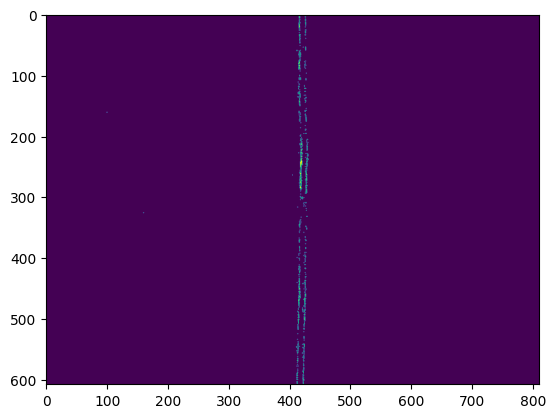

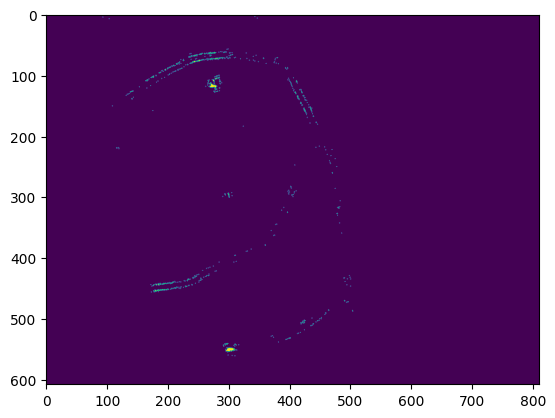

In [254]:

def rad_to_deg(rad):
    return 57.2958 * rad

image_center = tuple(np.array(aligned.shape[1::-1]) / 2)
aligned_r = cv2.warpAffine(aligned_t, cv2.getRotationMatrix2D(image_center, -rad_to_deg(theta_g), 1.0), aligned.shape[1::-1], flags=cv2.INTER_LINEAR)
misaligned_r = cv2.warpAffine(misaligned_t, cv2.getRotationMatrix2D(image_center, -rad_to_deg(theta_b), 1.0), aligned.shape[1::-1], flags=cv2.INTER_LINEAR)

plt.figure(1)
plt.imshow(aligned_r)
plt.figure(2)
plt.imshow(misaligned_r)

In [255]:
print(a_cx)

[392.02478]


In [256]:
solution = np.linalg.solve([
    [a_vx[0], -1],
    [a_vy[0], 0]
], [ -a_cx[0], (h/2) - a_cy[0] ])

In [259]:
position = [int(solution[1]), h//2]
print(solution[1] / w)

0.4832004015427384


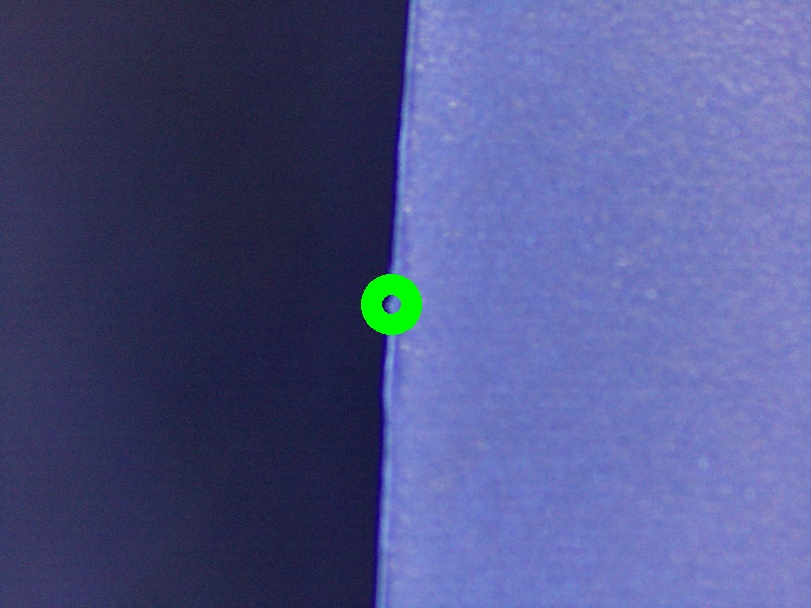

In [260]:
aligned_with_dot = cv2.circle(aligned.copy(), position, 20, (0, 255, 0), 20)
imshow(aligned_with_dot)

In [264]:
abs(0.5 - 0.4832004015427384)
IM_WIDTH_PER_EIGHTH_STEP = 0.0010059171597633137
edge_position = solution[1] / w
(edge_position - 0.5) / IM_WIDTH_PER_EIGHTH_STEP

-16.70077728986593